In [8]:
import torch
from torch import Tensor
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np 
from torch.utils.data import Dataset, DataLoader
import os 
from torchmetrics.classification.accuracy import BinaryAccuracy
import pandas as pd 
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T
import pickle 
import torchvision.transforms as TT 


In [9]:
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])



In [10]:
BASE_IMAGE_DIR= "ReinforcementImages"


In [11]:
from SegmentationAI import Decider 

dec = Decider() 


In [12]:
# TODO - Load images with their target values? 
resize_factor = T.Resize((128,128), antialias=True)
def load_and_clean(img_path):
    img = read_image(img_path,ImageReadMode.RGB)
    img = resize_factor.forward(img)  
    img = TT.ConvertImageDtype(torch.float32).forward(img) 

#     img = img.float() 
    img = img.unsqueeze(0) 
    
    img = dec.image_map(img) 
#     show(img) 
    
    return img 
possible_moves = ['up','left','right']

data_points = [] 

categorical_variables = {}
c_v_idx = 0 

for file in os.listdir(BASE_IMAGE_DIR):
    moves = set(file.split("_")).intersection(possible_moves) 
    formatted = [] 
    for m in possible_moves:
        if m in moves:
            formatted.append(m) 
    
    moves = " ".join(formatted)  
    if moves not in categorical_variables:
        categorical_variables[moves] = c_v_idx 
        c_v_idx += 1 
    moves = categorical_variables[moves] 
     
        
    img = load_and_clean(f"{BASE_IMAGE_DIR}/{file}")  
    data_points.append((img, moves))     

In [13]:
print(categorical_variables) 

{'up': 0, 'up left': 1, 'up right': 2, '': 3}


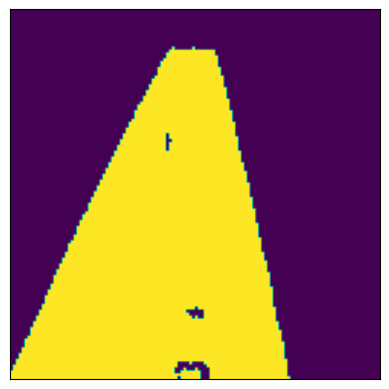

In [14]:
show(data_points[0][0].squeeze(0)) 

In [15]:
class CDS(Dataset):
    def __init__(self, lof_points):
        self.lof_points = lof_points 
    def __len__(self):
        return len(self.lof_points) 
    
    def __getitem__(self, idx):
        pair = self.lof_points[idx] 
        return pair 



dl_points = CDS(data_points) 
splits = torch.utils.data.random_split(dl_points, [len(data_points) - 10, 10])    
train = splits[0]
val = splits[1]
 

In [16]:

def highest_idx(vals):
    m = None
    out_idx = None 
    
    for idx, val in enumerate(vals):
        if m is None or val > m:
            m = val 
            out_idx = idx
    return out_idx 

class ImitationNN(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(in_features=128*128, out_features=len(categorical_variables)), 
        )
        
        self.loss = nn.CrossEntropyLoss()
        
        
        
          
    def configure_optimizers(self):

        optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        return optimizer 
    
    def training_step(self, batch, batch_idx):
        feats, target = batch 
        
        pred = self.forward(feats) 
        
        pred_idx = highest_idx(pred) 
        
        labels = torch.Tensor(np.zeros(len(pred)))
        labels[target] = 1 
        
        loss = self.loss(pred, labels)
        
        return loss 
          
        
    
    def validation_step(self, batch, batch_idx):
        feats, target = batch 
        pred = self.forward(feats) 
        
        pred_idx = highest_idx(pred) 
        
        labels = torch.Tensor(np.zeros(len(pred)))
        labels[target] = 1 
        
        loss = self.loss(pred, labels)
        
        return loss 
          

    def forward(self, x):
        flatten = torch.flatten(x) 
        return self.layers(flatten)  

print(train[0][0].shape)
model = ImitationNN() 


model.training_step(train[0], 0) 


torch.Size([1, 128, 128])


tensor(1.2213, grad_fn=<DivBackward1>)

In [17]:
trainer = pl.Trainer(max_epochs=5,
                     logger=pl.loggers.TensorBoardLogger('./voc'),
                     log_every_n_steps=1) 
trainer.fit(model=model, train_dataloaders=train, val_dataloaders=val) 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type             | Params
--------------------------------------------
0 | layers | Sequential       | 65.5 K
1 | loss   | CrossEntropyLoss | 0     
--------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1077/1077 [00:04<00:00, 241.48it/s, v_num=87]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1077/1077 [00:04<00:00, 232.27it/s, v_num=87]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1077/1077 [00:04<00:00, 234.49it/s, v_num=87]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1077/1077 [00:04<00:00, 232.03it/s, v_num=87]


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1077/1077 [00:04<00:00, 237.82it/s, v_num=87]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1077/1077 [00:04<00:00, 252.33it/s, v_num=87]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1077/1077 [00:04<00:00, 249.65it/s, v_num=87]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1077/1077 [00:04<00:00, 249.31it/s, v_num=87]


In [18]:
direct_mappings = {}

for key in categorical_variables:
    val = categorical_variables[key]
    direct_mappings[val] = key 

def predict(img):
    preds = model(img) 
    pred_idx = highest_idx(preds)
    
    return direct_mappings[pred_idx] 
    

In [19]:
test_files = []

for file in os.listdir("Images/"):
    img = load_and_clean(f"Images/{file}")
    test_files.append(img)
    
     

up left


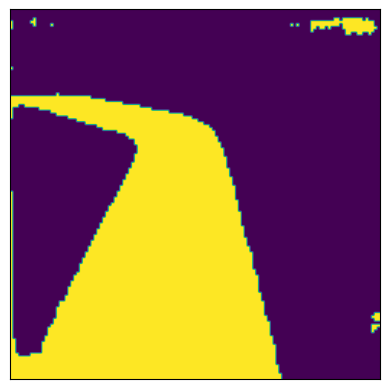

In [21]:
img = test_files[1]

show(img)
direct = predict(img) 
print(direct) 

In [22]:
if True:
    print("Saving mode!") 
    torch.save(model.state_dict(), "imitation_model_weights") 

Saving mode!


In [23]:
print(direct_mappings) 

{0: 'up', 1: 'up left', 2: 'up right', 3: ''}
